### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.applications.vgg19 import VGG19

### IMPORTING / VIEWING / PREPROCESSING DATASET

> `DATA AUGMENTATAION`

In [2]:
# Data Augmentation - Doing 80-20 split

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

In [3]:
train_dataset = train_datagen.flow_from_directory(directory = '../input/root-canal-1',
                                                  class_mode = 'binary',
                                                  target_size = (224,224),
                                                  subset = 'training')

Found 92 images belonging to 2 classes.


In [4]:
valid_dataset  = valid_datagen.flow_from_directory(directory = '../input/root-canal-1',
                                                   class_mode = 'binary',
                                                   target_size = (224,224),
                                                   subset = 'validation')

Found 23 images belonging to 2 classes.


In [5]:
# Checking the binary class labels.

train_dataset.class_indices

{'1_ROOT': 0, '2_MORE_ROOT': 1}

100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


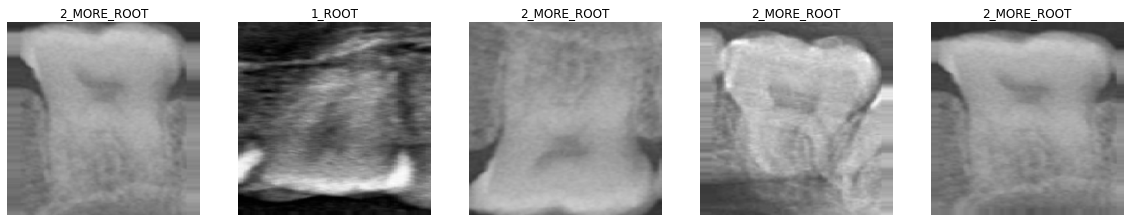

In [6]:
# Viewing Images 

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,20))

for i in tqdm(range(0, 5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(len(train_dataset))
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a == 0:
        ax[i].set_title("1_ROOT")
    else:
        ax[i].set_title("2_MORE_ROOT")

### MODEL BUILDING

In [7]:
# Initializing VGG-19 model

base_model = VGG19(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

80142336/80134624 [==============================] - 1s 0us/step


In [8]:
# Checking Summary 

base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [10]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [11]:
# Summary 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0

In [12]:
# Compiling Model

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name="auc")],
              optimizer=OPT)

In [13]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [14]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
3/3 [==============================] - ETA: 0s - loss: 0.8054 - auc: 0.6127
Epoch 00001: val_auc improved from -inf to 0.75769, saving model to ./best_weights.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.8054 - auc: 0.6127 - val_loss: 0.6359 - val_auc: 0.7577
Epoch 2/500
3/3 [==============================] - ETA: 0s - loss: 0.3317 - auc: 0.9240
Epoch 00002: val_auc improved from 0.75769 to 0.77308, saving model to ./best_weights.hdf5
3/3 [==============================] - 2s 727ms/step - loss: 0.3317 - auc: 0.9240 - val_loss: 0.5813 - val_auc: 0.7731
Epoch 3/500
3/3 [==============================] - ETA: 0s - loss: 0.3287 - auc: 0.9320
Epoch 00003: val_auc improved from 0.77308 to 0.83077, saving model to ./best_weights.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.3287 - auc: 0.9320 - val_loss: 0.6281 - val_auc: 0.8308
Epoch 4/500
3/3 [==============================] - ETA: 0s - loss: 0.3681 - auc: 0.9291
Epoch 00004: val_auc improv

### MODEL EVALUATION

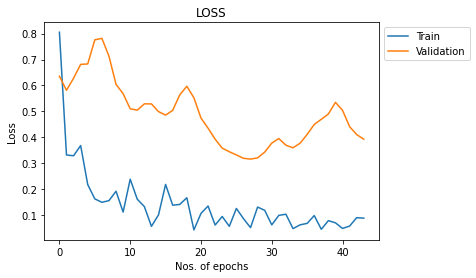

In [15]:
# LOSS 

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('LOSS')
plt.ylabel('Loss')
plt.xlabel('Nos. of epochs')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor = (1,1))
plt.show()

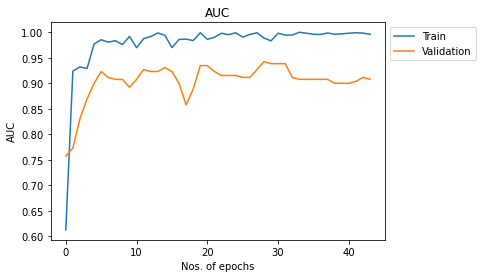

In [17]:
# AUC

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('AUC')
plt.ylabel('AUC')
plt.xlabel('Nos. of epochs')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor = (1,1))
plt.show()

In [ ]:
# TESTING ON IMAGES

> `CASE 1: 1_ROOT IMAGE`

It belongs to 1_ROOT


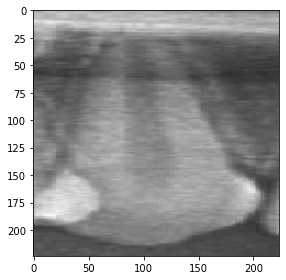

In [38]:
dict = train_dataset.class_indices
idc  = {k:v for v, k in dict.items()}

img = load_img('../input/root-canal-1/1_ROOT/1 root/tooth17.jpg', target_size=(224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
img = np.expand_dims(img, axis=0)
ans = model.predict_classes(img)
if ans[0][0] == 0:
    print("It belongs to 1_ROOT")
else:
    print("It belonsg to 2_MORE_ROOT")

> `CASE 2: 2_MORE_ROOT`

It belonsg to 2_MORE_ROOT


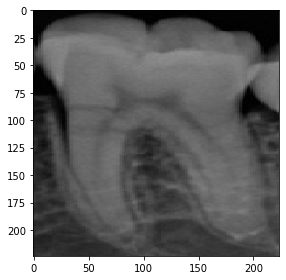

In [41]:
dict = train_dataset.class_indices
idc  = {k:v for v, k in dict.items()}

img = load_img('../input/root-canal-1/2_MORE_ROOT/2 or more roots/tooth1.jpg', target_size=(224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
img = np.expand_dims(img, axis=0)
answer = model.predict_classes(img)
if answer[0][0] == 0:
    print("It belongs to 1_ROOT")
else:
    print("It belong to 2_MORE_ROOT")
